*First compiled: September 16, 2017.*

# Graph Abstraction for Deep Learning

[Eulenberg, Köhler, *et al.*, Nat. Commun. (2017)](https://doi.org/10.1101/081364) showed that continuous biological processes can be reconstructed using deep learning. Their results can be reproduced from https://github.com/theislab/deepflow.

The graph of neighborhood relations of data points in pixel space is useless if computed with a simple distance metric (euclidian, cosine, correlation-based, etc.). Deep Learning generates a feature space in which data points are positioned according to biological similarity and hence generates a distance metric that is much more valuable. Here, we demonstrate how graph abstraction is applied in this case.

A video on how the deep learning based feature space organizes data according to biological similarity is here: https://youtu.be/eyWcHIiCazE. 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy.api as sc

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+14.gdc3fb50.dirty on 2017-09-16 14:44.


Download the features of [Eulenberg, Köhler, *et al.*, Nat. Commun. (2017)](https://doi.org/10.1101/081364) [here](http://falexwolf.de/scanpy_usage/170529_images/).

In [6]:
adata = sc.read('./DeepFlow_data/stain/stain_G1SG2_features.csv', cache=True)
annotation = pd.read_csv('./DeepFlow_data/stain/stain_G1SG2.lst', delimiter='\t', header=None)

reading file ./write/data/DeepFlow_data/stain/stain_G1SG2_features.h5


In [7]:
annotation.head()

,0,1,2
0,2,0.584232,../images/G2/40531_bright_field.jpg
1,12,0.555460,../images/G2/9425_bright_field.jpg
2,23,0.833180,../images/G2/28599_bright_field.jpg
3,40,0.628845,../images/G2/33523_bright_field.jpg
4,50,0.522287,../images/G2/16060_bright_field.jpg


In [10]:
adata.smp['cell_cycle_stages'] = annotation[2].str.lstrip('../images').str.split('/').str[0]
adata.smp['DNA_content'] = annotation[1]
adata.add['iroot'] = np.argmin(annotation[1])

In [11]:
sc.tl.tsne(adata)
sc.write('deepflow', adata)

computing tSNE
    preprocess using PCA with 50 PCs
--> avoid this by setting n_pcs = 0
    using 50 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:08.475) and added
    "X_tsne", tSNE coordinates (adata.smp)
writing ./write/deepflow.h5


reading file ./write/deepflow.h5


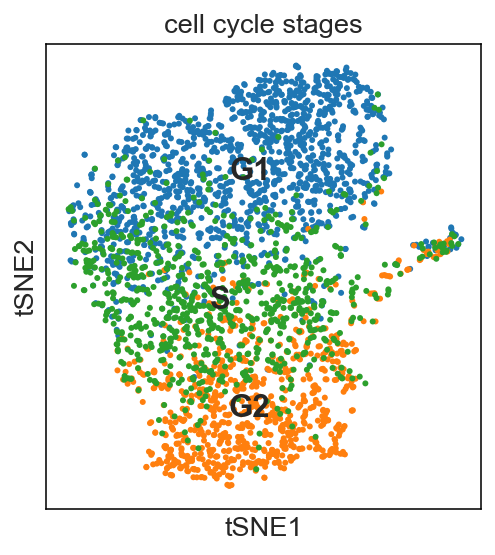

In [6]:
adata = sc.read('deepflow')
axs = sc.pl.tsne(adata, legend_loc='on data', legend_fontsize=16, legend_fontweight='bold',
                 color='cell_cycle_stages')

In [13]:
sc.tl.aga(adata, resolution=0.5, recompute_louvain=True)
sc.write('deepflow', adata)

running Louvain clustering
    using "X_pca" for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9831937551  0.9409672618  0.9034593105  0.8945518732
      0.8453648686  0.8430890441  0.8215581775  0.8133733869  0.8022948503]
    using the "louvain" package of Traag (2017)
    finished (0:00:02.726) and found 4 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_order", the unique cluster labels (adata.add)
running Approximate Graph Abstraction (AGA)
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 30 and spectrum
    [ 1.            0.9831937551  0.9409672618  0.9034593105  0.8945518732
      0.8453648686  0.8430890441  0.8215581775  0.8133733869  0.8022948503]
    abstracted graph will have 4 nodes
... finished (0:00:00.390) --> added
    aga_adjacency_full_attachedness : n

reading file ./write/deepflow.h5
... you are using a very low resolution for saving figures, adjusting to dpi=300
... saving figure to file ./figures/aga.png


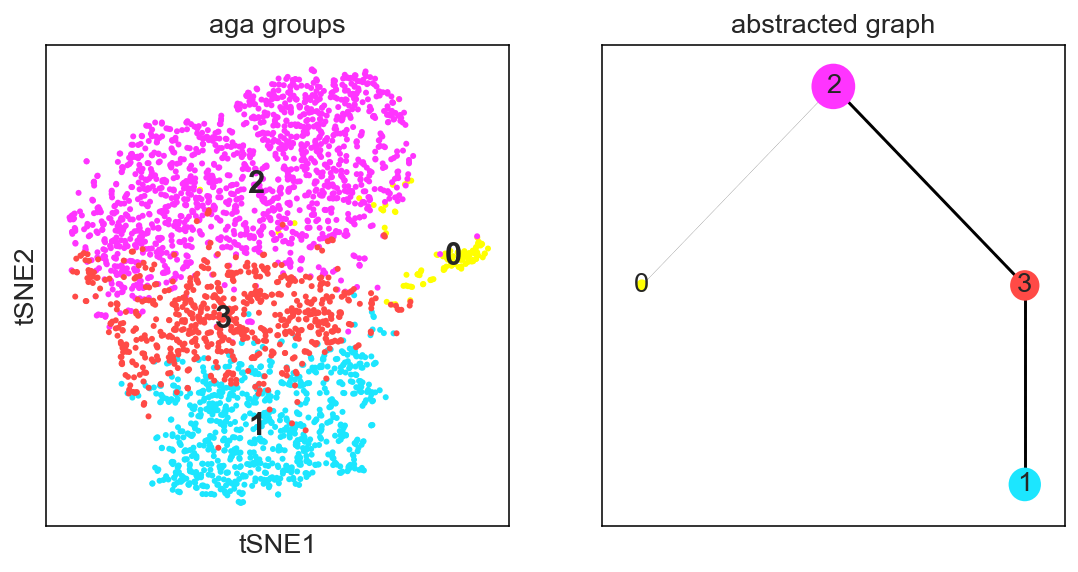

In [2]:
adata = sc.read('deepflow')
sc.pl.aga(adata, palette=sc.pl.palettes.godsnot_64, color='aga_groups', groups_graph='aga_groups', 
          legend_fontsize=16, legend_fontweight='bold',
          title_graph='abstracted graph',
          root=2, layout='rt', frameon=True, save=True, show=True)

In [3]:
asso_groups, asso_matrix = sc.utils.compute_association_matrix_of_groups(adata, 'aga_groups', 'cell_cycle_stages')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)

... saving figure to file ./figures/aga_cell_cycle_stages.png


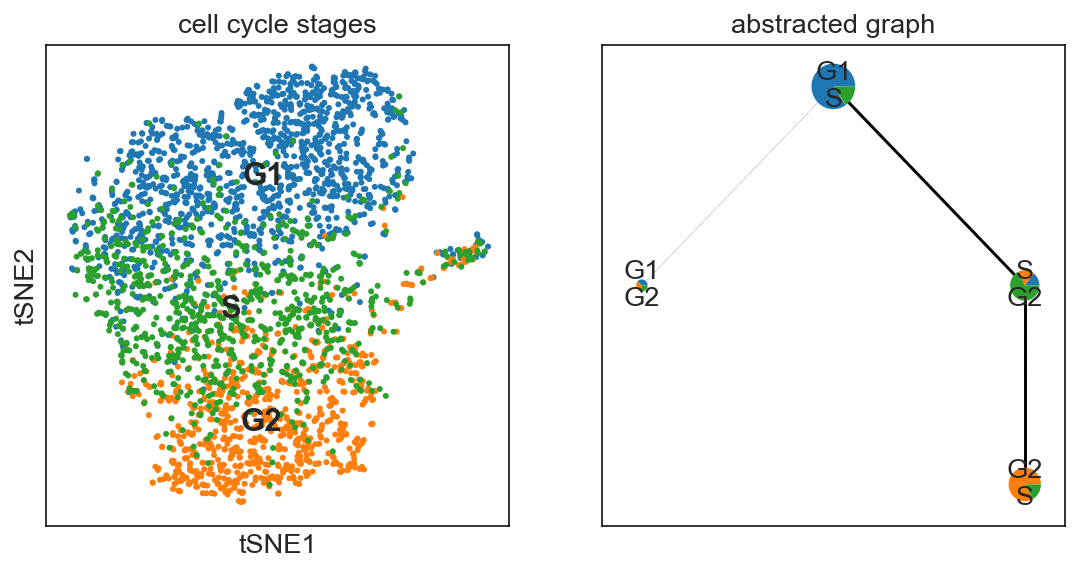

In [7]:
ax = sc.pl.aga(adata, color='cell_cycle_stages', title_graph='abstracted graph',
               legend_fontsize=16, legend_fontweight='bold',
               color_graph=asso_colors,
               groups_graph=asso_groups, title='cell cycle stages', 
               root=2, layout='rt', frameon=True, show=True, save='_cell_cycle_stages')